In [1]:
import string
import copy
import scipy
import Tkinter, tkFileDialog
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import sys
import datetime
import matplotlib.units
import re
from numba import jit,int32
import time
from PIL import Image
import pims
import glob
sys.path.append(os.path.abspath("C:\Users\Scherer Lab E\Documents\GitHub\Python_Data_Analysis"))
import common_functions
import half_nanoplate_functions as hnf

C:\Users\Scherer Lab E\Anaconda2\envs\170112\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [68]:
import matplotlib as mpl
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# Import Data
## Import Position Data of Particles
By importing the raw localized positions of particles I can use their positions to find frames where particles are far from the nanoplate edge (just like in `Ana_16052401`). From images where particles are not near the edge I can construct a median or an average to calculate the edge of.

In [2]:
'''Import the Matlab Gui Data'''
data_dir="C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version"
os.chdir(data_dir)
file_list_proc = glob.glob('Mov_012014*pre-linking_processed.mat')
data_list_proc = [common_functions.import_matlab_gui(i) for i in file_list_proc]
data_list_proc = [common_functions.matlab_gui_to_data_frame(i) for i in data_list_proc]

Loading Mov_01201403_pre-linking_processed.mat
Loading Mov_01201404_pre-linking_processed.mat
Loading Mov_01201405_pre-linking_processed.mat
Loading Mov_01201406_pre-linking_processed.mat
Loading Mov_01201407_pre-linking_processed.mat
Loading Mov_01201408_pre-linking_processed.mat


In [3]:
os.chdir("J:\Pat's Projects\Dynamical Phase Transition\Exp01201401\Half over Nanoplate")

In [4]:
folder_list = glob.glob("Mov_012*L=?\\")

In [5]:
'''Do y-flip of position data and add polar coordinates'''
transformed_data_list_proc = []
for df in data_list_proc:
    new_flip = common_functions.y_axis_flip(df, 390)
    temp_fit_params = common_functions.least_sq_fit_circle(new_flip)
    common_functions.polar_coor_data_frame(new_flip, temp_fit_params[0], temp_fit_params[1])
    transformed_data_list_proc.append(new_flip)

# Image Processing
### Construct median from images of particles far from the edge
Just like in `Ana_16052501` I create a image which is the median of the experiment including only frames where the particles are far from the nanoplate edge. Part of this image will be fit with a line to find the edge.

In [6]:
def find_frames_with_no_particles_in_theta_region(df, theta_limits, buffer_time=1):
    """Finds frames where there are no particles in a defined theta region for 
    time +/- the buffer time
    
    :params df: The DataFrame with all the particle trajectories.
    :params theta_limits: List of length 2 that defines the lower and upper
    bounds of theta that there could be no particles.
    :params buffer_time: the number of frames before and after finding a frame
    with no particles must there also be no particles to be counted."""
    
    df_theta = df.query('@theta_limits[0] < theta < @theta_limits[1]')
    unique_frames = df_theta.drop_duplicates(subset='frame')
    
    low_frames = unique_frames[unique_frames.frame.shift(-1) - unique_frames.frame > 1+2*buffer_time]
    high_frames = unique_frames[unique_frames.frame - unique_frames.frame.shift(1) > 1+2*buffer_time]
    zipped_frames = zip(low_frames.frame, high_frames.frame)
    frame_list = []
    for low, high in zipped_frames:
        frame_list += range(int(low)+1+buffer_time, int(high)-buffer_time)
    return frame_list

Calculate the median of frames w/o particles near the barrier

In [7]:
median_list = []
for num, folder in enumerate(folder_list):
    print folder
    image_seq = pims.ImageSequence(folder+'*.tif')
    frames = find_frames_with_no_particles_in_theta_region(transformed_data_list_proc[num], theta_limits=[240,300], buffer_time=1)
    median = np.median(image_seq[frames], axis=0)
    median_list.append(median)

Mov_01201403 - L=1\
Mov_01201404 - L=2\
Mov_01201405 - L=3\
Mov_01201406 - L=4\
Mov_01201407 - L=5\


### Image Processing and Fitting Line
In order to determine the location of the edge I had to do several image processing steps to the median images. Here are the steps:

1. The median of a specific L is selected 
![Data/Figures for Notebooks/17030401 Median Image.png](Data/Figures for Notebooks/17030401 Median Image.png)

2. The image is thresholded with an Otsu threshold (default parameters) 
![Data/Figures for Notebooks/17030401 Thresholded Image.png](Data/Figures for Notebooks/17030401 Thresholded Image.png)

3. The binary image is filtered so only large object are kept and small objects are removed. 
![Data/Figures for Notebooks/17030401 Cleaned Thresholded Image.png](Data/Figures for Notebooks/17030401 Cleaned Thresholded Image.png)

4. The binary image is multiplied by the original median image to mask off the data. Then only a section of the image is selected for the fitting (select the last 115 pixels in x to get just the falling edge of the nanoplate) 
![Data/Figures for Notebooks/17030401 Cut and Masked Median.png](Data/Figures for Notebooks/17030401 Cut and Masked Median.png)

5. A line is fit to all the points in the image where each point is weighted by the square root of the intensity (black pixels are not weighted at all and brightest pixels weighted the most).
![Data/Figures for Notebooks/17030401 Fit Line to Median.png](Data/Figures for Notebooks/17030401 Fit Line to Median.png)


In [8]:
import skimage

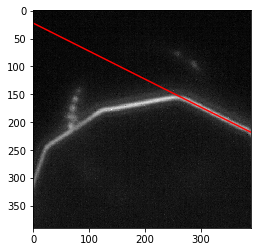

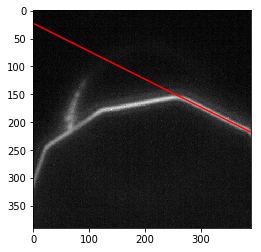

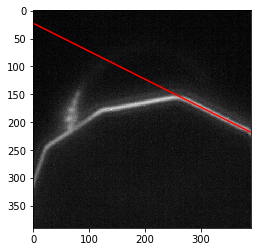

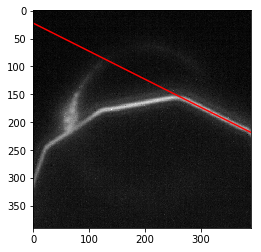

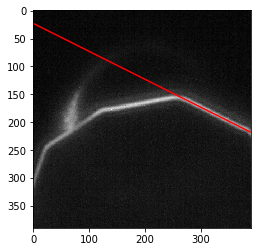

In [45]:
edge_functions = []
edge_params = []
for img in median_list:
    # Threshold the image to get just the edge
    thresh = skimage.filters.threshold_otsu(img)
    thresh_img = img > thresh
    # Cleanup binary image
    test_filter = scipy.ndimage.binary_opening(thresh_img)
    # Mask the original image with the binary
    masked = test_filter * img
    masked_barrier = masked[:,275:]
    
    # Fit a line to the image using the intensity as weighting
    y, x = np.indices(masked_barrier.shape)
    valid_z = (y.ravel() > 0) & (masked_barrier.ravel() > 0)
    x_valid = x.ravel()[valid_z]
    y_valid = y.ravel()[valid_z]
    z_valid = masked_barrier.ravel()[valid_z]
    
    z = np.polyfit(x_valid, y_valid, w=z_valid**0.5, deg=1)
    edge_params.append(z)
    p = np.poly1d(z)
    edge_func = lambda x: p(x - 275)
    edge_functions.append(edge_func)
    
    # Plot line on full image
    plt.figure()
    plt.imshow(img, cmap='gray', vmin=100, interpolation='none')

    plt.plot(np.arange(img.shape[0]), p(np.arange(img.shape[0]) - 275), 'r')
    plt.show()

### Find the lines that describe the limit of the edge of the Au nanoplate

This analysis was done to determine the location of the limits of the bright band in the microscopy image are. The way this was done is similar to the steps outlined in `Ana_17030401 - Determine Location of Edge` except it deviates after step 3. 

1. Thresholding - Here I thre using a specific value instead of one of the common threshold algorithms. In `Ana_17030401` I used an Otsu threshold algorithm but it was capturing too much of the bright band so I needed a little bit finer control. Here I used a set value to threshold by (intensity > 141) which I determined manually by looking at the gray levels in the image and selecting where I want the edges of the threshold to reach.

2. Filter thresholded data - This is the same step as in `Ana_17030401` to remove spurious thresholded features.

3. Edge Detection - I used an edge detection algorithm (Roberts method) to detect the edges of my binary image. Since a binary image is very easy to detect edges of I got two lines of pixels corresponding to the top and bottom parts of the intensity band of the nanoplate. Shown below is the image after edge detection zoomed in on the falling edge of the experiment.
![Data/Figures for Notebooks/17031302 Edge Detected Thresholded Image.png](Data/Figures for Notebooks/17031302 Edge Detected Thresholded Image.png)

4. Line Fitting - Using my lines from `Ana_17030401` I can select pixels that are above ore below the center line I generated previously. For each set of these pixels I can fit a line using the intensities (in the edge detected image) as the fit. Below you can see the final result of fitting the two lines.
![Data/Figures for Notebooks/17031302 Fit to band edges.png](Data/Figures for Notebooks/17031302 Fit to band edges.png)

In [46]:
def fit_line_to_image(img):
    y, x = np.indices(img.shape)
    valid_z = (y.ravel() > 0) & (img.ravel() > 0)
    x_valid = x.ravel()[valid_z]
    y_valid = y.ravel()[valid_z]
    z_valid = img.ravel()[valid_z]
    
    z = np.polyfit(x_valid, y_valid, w=z_valid**0.5, deg=1)
    return z

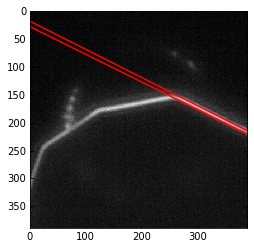

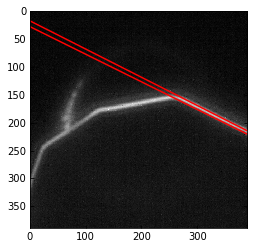

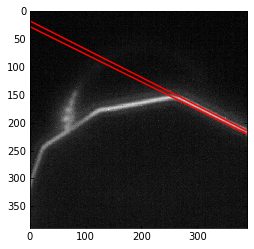

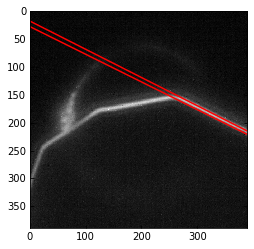

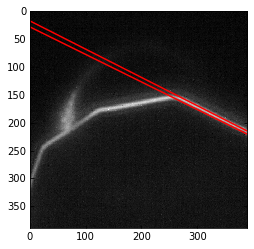

In [79]:
above_below_edge_params = []
for num, img in enumerate(median_list):
    # Threshold the image to get just the edge, chose 141 manually
    thresh_img = img > 141
    test_filter = scipy.ndimage.binary_opening(thresh_img)
    
    # Do edge detetion on binary image and select relavent part of image
    edge_detect = skimage.filters.roberts(test_filter)
    edge_detect = edge_detect[:,275:]
    
    # Get the function for the center of the edge
    p = np.poly1d(edge_params[num])
    
    # Segment edge detected image from edge above/below center line
    y_ind, x_ind = np.indices(edge_detect.shape)
    above_line = p(x_ind) > y_ind
    below_line = p(x_ind) < y_ind
    
    edge_above_line = edge_detect * above_line
    edge_below_line = edge_detect * below_line
    
    # Find the line for each part of the edge
    above_edge_param = fit_line_to_image(edge_above_line)
    below_edge_param = fit_line_to_image(edge_below_line)
    
    above_below_edge_params.append((above_edge_param, below_edge_param))
    
    p_above = np.poly1d(above_edge_param)
    p_below = np.poly1d(below_edge_param)
    
    plt.figure()
    plt.imshow(img, cmap='gray', vmin=100, interpolation='none')
    plt.plot(np.arange(img.shape[0]), p_above(np.arange(img.shape[0]) - 275), 'r')
    plt.plot(np.arange(img.shape[0]), p_below(np.arange(img.shape[0]) - 275), 'r')
    plt.show()

## Open trajectory data and calculate proper distance to edge

Now that I have a line that defines the edge of the nanoplate I can find where that line intersects the ring trap in each experiment. The theta position of that intersection will be used in the arc length calculation of the distance to the edge.

In [48]:
store = pd.HDFStore("K:\Pat's_Projects\ParticleTrajectoryData\half_nanoplate_dynamics_processed.h5", mode='r')
keys = store.index['key']
np_pos = [store.get(v).drop_duplicates(['frame', 'track id']).copy() for v in keys[:-1]]
store.close()

Write functions to find the distance to the edge along the arc of the average radius

In [49]:
def find_circle_line_intersection(r_avg, x_cent, y_cent, slope, y_int):
    """Finds where a line interesects a circle"""
    a = 1 + slope**2
    b = -2*x_cent + 2*slope*y_int - 2*slope*y_cent
    c = -r_avg**2 + x_cent**2 + y_int**2 - 2*y_int*y_cent + y_cent**2

    x1 = (-b + (b**2 - 4*a*c)**0.5)/(2*a)
    x2 = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    
    y1 = slope*x1 + y_int
    y2 = slope*x2 + y_int
    
    return [(x1, y1), (x2, y2)]

def find_edge_in_theta(df, slope, y_int):
    """Calculates the position (in theta) where the edge of the nanoplate 
    (defined by a function of a line) intersects with the ring trap.
    
    :param df: DataFrame of particle positions in the half nanoplate experiment
    :param slope: The slope of the edge in the image data. The slope will be 
    flipped in y to match the trajectory data and will be shifted by 275 pixels
    to account for the lines' position in the full frame
    :param y_int: the y intercept of the fit to the edge of the nanoplate
    """
    near_edge = df.query('245 < theta < 310')
    r_avg = near_edge.r.mean()
    #print "r_avg1 ="+str(r_avg)
    r_avg = near_edge.query('@r_avg-10 < r < @r_avg+10').r.mean()
    #print slope, y_int, r_avg
    # Get relavent polar coordinate info
    x = df.loc[0, 'x pos']
    y = df.loc[0, 'y pos']
    r = df.loc[0, 'r']
    theta = df.loc[0, 'theta']
    x_cent, y_cent = common_functions.calc_cent_from_polar(x, y, r, theta)
    #print x_cent, y_cent
    y_int_cor = slope*(-275) + y_int
    slope_cor = -slope
    y_int_cor = -y_int_cor + 390
    
    int_1, int_2 = find_circle_line_intersection(r_avg, x_cent, y_cent, slope_cor, y_int_cor)
    
    ang_1 = common_functions.calc_angle(int_1[0], int_1[1], x_cent, y_cent)
    ang_2 = common_functions.calc_angle(int_2[0], int_2[1], x_cent, y_cent)
    
    return ang_1, ang_2
    
find_edge_in_theta(np_pos[0], edge_params[0][0], edge_params[0][1])

(274.78502148619356, 31.960413043995914)

## Calculate Intersection of the Edges of the Band Above/Below Center

This section deals with finding the intersection (in theta) with the two lines that make up the edges of the band seen in the microscopy image. One is above the center band and the other is below the center band. I report below the difference each edge is from the center definition of the edge (in um). On one side of the band the distance from the fitted center is more than the other side of the band.

In [53]:
edge_loc_theta_range = []
for num, df in enumerate(np_pos):
    edge_loc = {}
    above_edge = above_below_edge_params[num][0]
    below_edge = above_below_edge_params[num][1]
    ang1_above, ang2_above = find_edge_in_theta(df, above_edge[0], above_edge[1])
    ang1_below, ang2_below = find_edge_in_theta(df, below_edge[0], below_edge[1])
#     print "Top Edges at ="+str(ang1_above)+" degrees\n"
#     print "Bottom Edges at ="+str(ang1_below)+" degrees\n"
    
    slope = edge_params[num][0]
    y_int = edge_params[num][1]
    ang1, ang2 = find_edge_in_theta(df, slope, y_int)
    
    edge_loc['above'] = ang1_above
    edge_loc['below'] = ang1_below
    edge_loc['middle'] = ang1
    edge_loc_theta_range.append(edge_loc)
#     print "Center Edges at ="+str(ang1)+" degrees\n"
    
um_conv=6.5/60/1.6/2
curve_colors = ['k', '#d62728', '#1f77b4']
avg_r_ls = []
log_pd_ls = []
edge_dist_ls = []
theta_ls = []
for num, v in enumerate(np_pos):
    
    edge_barrier = v.query('248 < theta < 310')
    r_avg = edge_barrier.r.mean()
    edge_barrier = edge_barrier.query('@r_avg-10 < r < @r_avg+10')
    r_avg = edge_barrier.r.mean()
    avg_r_ls.append(r_avg)
    theta_edge_values = edge_loc_theta_range[num]
    center_edge = theta_edge_values['middle']
    range_above = theta_edge_values['above']
    range_below = theta_edge_values['below']
    
    range_above = (range_above - center_edge) * um_conv * r_avg * np.pi/180
    range_below = (range_below - center_edge) * um_conv * r_avg * np.pi/180
    print "For L="+str(num+1)+":\n"+"Edge Range is +"+str(range_above)+" to "+str(range_below)

For L=1:
Edge Range is +0.131992079315 to -0.111774803278
For L=2:
Edge Range is +0.125403841586 to -0.11002947718
For L=3:
Edge Range is +0.124914404167 to -0.106153484593
For L=4:
Edge Range is +0.125165374978 to -0.107818694165
For L=5:
Edge Range is +0.118638190695 to -0.103718324782


## Make Figure Comparing Center Edge to Earlier Edge

Below I make some figures comparing the -log(PD) depending on which definition of the edge you use. The top row defines the edge as the center of the scattered light band while the bottom row uses the earlier (edge below center) definition of the edge. The edges are drawn on a microscopy image of the experiment and the -log(PD) are shown using each definition of the edge.

L=1


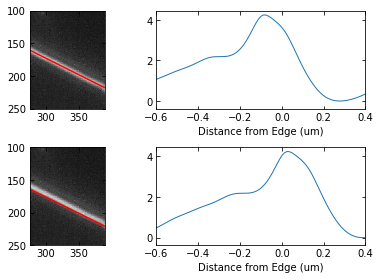

L=2


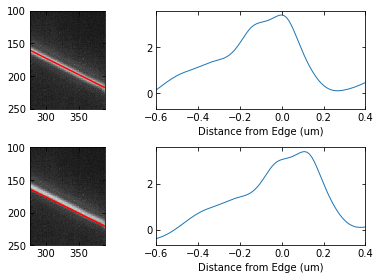

L=3


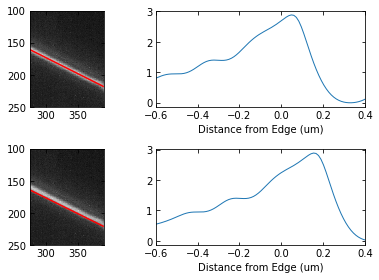

L=4


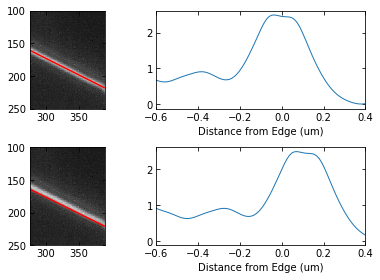

L=5


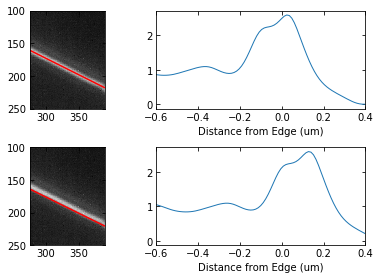

In [71]:
um_conv=6.5/60/1.6/2
#curve_colors = ['k', '#d62728', '#1f77b4']
avg_r_ls = []
log_pd_ls = []
edge_dist_ls = []
theta_ls = []
export_data_list = []
for num, v in enumerate(np_pos):
    images_and_curves = {}
    
    edge_comparison_fig = plt.figure()
    
    edge_barrier = v.query('248 < theta < 310')
    r_avg = edge_barrier.r.mean()
    edge_barrier = edge_barrier.query('@r_avg-10 < r < @r_avg+10')
    r_avg = edge_barrier.r.mean()
    avg_r_ls.append(r_avg)
    theta_edge_values = edge_loc_theta_range[num]
    center_edge = theta_edge_values['middle']
    range_above = theta_edge_values['above']
    range_below = theta_edge_values['below']
    
    # Histogram of Positions
    bin_num = hnf.hist_bin_optimization_continuous(edge_barrier.theta)
    hist, bins = np.histogram(edge_barrier['theta'], bins=bin_num, normed=True)
    kernel = scipy.stats.gaussian_kde(edge_barrier['theta'], bw_method=0.04)
    theta_range = np.linspace(249,309,400)
    
    # PMF
    pmf = -np.log(kernel.evaluate(theta_range))
    bins_mid = (bins[:-1] + bins[1:])/2.0
    edge_dist_center = (theta_range-center_edge) * (np.pi/180) * r_avg * um_conv
    edge_dist_above = (theta_range-range_below) * (np.pi/180) * r_avg * um_conv
    
    median_img = median_list[num]
    edge_line_x = np.arange(median_img.shape[0])
    
    end_pmf = pmf[len(pmf)/3:]
    plt.subplot(221)
    plt.imshow(median_img, cmap='gray')
    
    edge_params_l = edge_params[num]
    p = np.poly1d(edge_params_l)
    plt.plot(edge_line_x, p(edge_line_x-275), 'r')
    plt.xlim(275,390)
    plt.ylim(250, 100)
    
    images_and_curves['edge_y_center'] = p(edge_line_x-275)

    print "L="+str(num+1)
    
    plt.subplot(222)
    plt.plot(edge_dist_center, pmf-min(end_pmf), label='$l$='+str(num+1), lw=1)
    plt.xlim(-0.6, 0.4)
    plt.xlabel('Distance from Edge (um)')
    
    plt.subplot(223)
    plt.imshow(median_img, cmap='gray')
    
    edge_params_above_l = above_below_edge_params[num][1]
    p = np.poly1d(edge_params_above_l)
    
    plt.plot(edge_line_x, p(edge_line_x-275), 'r')
    plt.xlim(275,390)
    plt.ylim(250, 100)
    
    images_and_curves['edge_y_above'] = p(edge_line_x-275)

    plt.subplot(224)
    plt.plot(edge_dist_above, pmf-min(end_pmf), label='$l$='+str(num+1), lw=1)
    plt.xlim(-0.6, 0.4)
    plt.xlabel('Distance from Edge (um)')
    plt.tight_layout()
    plt.show()
    
    images_and_curves['logpd'] = pmf-min(end_pmf)
    images_and_curves['edge_dist_center'] = edge_dist_center
    images_and_curves['edge_dist_above'] = edge_dist_above
    images_and_curves['edge_x'] = edge_line_x
    images_and_curves['median_image'] = median_img
    
    export_data_list.append(images_and_curves)
# plt.xlabel('Distance from Edge ($\mathregular{\mu}$m)', labelpad=0.5)
# plt.ylabel(r'$-\log(PD)$ ($\mathregular{k_BT}$)')

## Write to pickle file

Save relevant variables to a pickle file for plotting the figures for the paper SI. Exporting only the L=3 data for the SI.

In [74]:
import cPickle

f = open("C:\Users\Scherer Lab E\Box Sync\Half-Nanoplate\Figures and Data\Data\\edge_definition.pkl", 'w')
cPickle.dump(export_data_list[2], f)
f.close()